In [1]:
%load_ext rmagic

/usr/local/lib/python2.7/dist-packages/IPython/extensions/rmagic.py:693: UserWarning: The rmagic extension in IPython is deprecated in favour of rpy2.ipython. If available, that will be loaded instead.
http://rpy.sourceforge.net/
  warnings.warn("The rmagic extension in IPython is deprecated in favour of "


# [導讀] 股票市場的預測
* <a href='http://www.pcstore.com.tw/pchome24h/M19720645.htm'>基礎R語言與商業應用：第八章</a>
* C.Y. Yen
* October @ R 商應

## Who am I ?
* Yen
* yen.chiayi@gmail.com
* NTU Economics
* 避險基金財務工程師
* 工作涵蓋
    * 多因子模型的建構
    * 資料 Extract-Transform-Load
    * 機器學習
    * 各種數值分析
    
##### --
 * 熱衷於參與 open source 社群活動，特別是與 Python 或 R 有關的活動
 * 是 TW R-Ladies 的發起人之一

## Outline
* 策略：擇時買入/放空 SSEC (上海證券交易所綜合股價指數)，並持有10天
* 問題
    1. 使用歷史價格
    2. 預測單一股票未來10天的績效表現
    3. 以此決定今天是否進行交易

## Outline
* 處理流程
    1. 取得股價時間序列
    2. 設定預測目標
    3. 設定預測變數
    4. 建模型
    5. 評估模型表現

## Outline
* 處理流程
    1. 取得股價時間序列：以 quantmod 取得資料，以 xts 套件整理資料
    2. 設定預測目標：未來10天的績效
    3. 設定預測變數：過去的歷史價格所組成的各種指標，以 Random Forest 選擇重要的變數 (降維)
    4. 建模型：以 Support Vector Machine 做預測
    5. 評估模型表現：命中率

### 在這個章節中，你需要了解的 Machine Learning Algorithm
* Random Forest 隨機森林
* Support Vector Machine 支援向量機

#### <a href='http://www.slideshare.net/DebdootSheet/decision-trees-and-random-forests'>Decision Tree & Random Forest</a>
* 用來分類
* 用來衡量變數的重要性
<img src='fig/decision_tree.jpg'>
###### reference:http://www.slideshare.net/DebdootSheet/decision-trees-and-random-forests

In [2]:
%%R
data_ <- data.frame(
    target=c('w', 's', 'q', 'p'), 
    reproduce = c(TRUE, TRUE, FALSE, FALSE),
    oversize=c(TRUE, TRUE, FALSE, FALSE),
    wing=c(TRUE,  FALSE, TRUE, FALSE)
)
data_

  target reproduce oversize  wing
1      w      TRUE     TRUE  TRUE
2      s      TRUE     TRUE FALSE
3      q     FALSE    FALSE  TRUE
4      p     FALSE    FALSE FALSE


<img src='fig/random_forest.jpg'>
###### reference:http://www.slideshare.net/DebdootSheet/decision-trees-and-random-forests

<img src='fig/random_forest_ensemble.png' height=360>
###### reference:http://gallery.azureml.net/Experiment/b729c21014a34955b20fa94dc13390e5

#### <a href='https://cg2010studio.wordpress.com/2012/05/20/%E6%94%AF%E6%8C%81%E5%90%91%E9%87%8F%E6%A9%9F%E5%99%A8-support-vector-machine/'>Support Vector Machine</a>
<img src='fig/svm_spirit.png'>
###### reference:https://cg2010studio.wordpress.com/2012/05/20/%E6%94%AF%E6%8C%81%E5%90%91%E9%87%8F%E6%A9%9F%E5%99%A8-support-vector-machine/

 #### 1. 取得股價時間序列：以 quantmod 取得資料，以 xts 套件整理資料

In [3]:
%%R
library(quantmod)
. <- getSymbols(Symbols = "^SSEC",src = "yahoo")
head(SSEC)

Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.
    As of 0.4-0, ‘getSymbols’ uses env=parent.frame() and
 auto.assign=TRUE by default.

 This  behavior  will be  phased out in 0.5-0  when the call  will
 default to use auto.assign=FALSE. getOption("getSymbols.env") and 
 getOptions("getSymbols.auto.assign") are now checked for alternate defaults

 This message is shown once per session and may be disabled by setting 
 options("getSymbols.warning4.0"=FALSE). See ?getSymbol for more details
           SSEC.Open SSEC.High SSEC.Low SSEC.Close SSEC.Volume SSEC.Adjusted
2007-01-04  2728.188  2847.615 2684.818   2715.719      120200      2715.719
2007-01-05  2668.577  2685.804 2617.019   2641.334      106200      2641.334
2007-01-08  2621.068  2708.444 2620.625   2707.199      10680

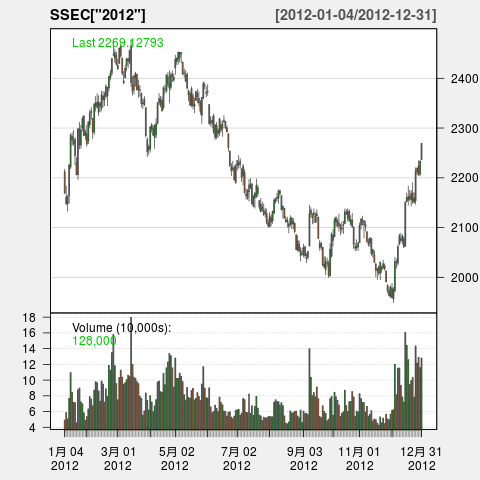

In [4]:
%%R
candleChart(x=SSEC["2012"], theme="white")

#### package: xts 使用方式

In [5]:
%%R
library(xts)
x <- xts(x=data.frame(x=1:13,y=13:1), order.by=seq(from=as.POSIXct("2012-05-23"),length.out=13,by="day"))
class(x)
x[1:2,]
x["2012-05-23"]
x["2012-05-29/"]
x["2012-05-21/2012-05-23"]
x["2012-05-23"]
x["2012-06"]

            x y
2012-06-01 10 4
2012-06-02 11 3
2012-06-03 12 2
2012-06-04 13 1


#### 2. 設定預測目標： 未來十天的績效表現
   

##### 使用均價比收盤價更穩定
<br>
$${avg.price}_t = \frac{Close_t+High_t+Low_t}{3}$$
<br>
$${return}_t=\frac{P_t-P_{t-1}}{P_{t-1}}$$
<br>
$$10-days~culmulated~return = \sum_{k=1}^{10}(return_k)$$

In [6]:
%%R
get.10.days.culmulated.return <- function(data, ndays, p=0.025){
    price <- get.avg.price(data)
    returns.in.10.days <- sapply(1:ndays, function(x) get.return(price, period=x))
    target <- apply(returns.in.10.days, 1, function(x) sum(x[abs(x)>p]))# 
    xts(x=target, order.by=time(SSEC))
}
get.avg.price <- function(data){
    hlc <- HLC(data)
    rowMeans(hlc)    
}
get.return <- function(price.xts, period){
    return.xts <- Delt(price.xts, k=period)
    Next(return.xts, k=period)   
}

In [8]:
%%R
target <- get.10.days.culmulated.return(data=SSEC, ndays=10)                    
head(target)

                  [,1]
2007-01-04 -0.06254482
2007-01-05  0.41123397
2007-01-08  0.37766541
2007-01-09  0.10595879
2007-01-10  0.06239784
2007-01-11  0.15280652


#### 3. 預測變數是什麼：以 Random Forest 選擇重要的變數 (降維)

In [25]:
%%R
library(TTR)
myTTR <- function(data)
{
  names(data) <- sapply(X=names(SSEC),FUN=function(x) strsplit(x,split=".",fixed=TRUE) [[1]] [2])
  myATR <- ATR(HLC(data))$atr
  mySMI <- SMI(HLC(data))$SMI
  myADX <- ADX(HLC(data))$ADX
  myAroon <- aroon(HLC(data)[,-3])$oscillator
  myBBands <- BBands(HLC(data))$pctB
  myChaikin <- Delt(chaikinVolatility(HLC(data)[,-3]))[,1]
  myCLV <- EMA(CLV(HLC(data)))[,1]
  myMACD <- MACD(data[,"Close"])[,2]
  myMFI <- MFI(data[,c("High","Low","Close")],data[,"Volume"])
  mySAR <- SAR(data[,c("High","Close")])[,1]
  result <- cbind(myATR,mySMI,myADX,myAroon,myBBands,myChaikin,myCLV,myMACD,myMFI,mySAR)
  colnames(result) <- c("myATR","mySMI","myADX","myAroon","myBBands","myChaikin","myCLV","myMACD","myMFI","mySAR")
  return(result)
}

X <- myTTR(SSEC)
print(colnames(X))
head(X,25)

 [1] "myATR"     "mySMI"     "myADX"     "myAroon"   "myBBands"  "myChaikin"
 [7] "myCLV"     "myMACD"    "myMFI"     "mySAR"    
               myATR mySMI myADX myAroon    myBBands  myChaikin       myCLV
2007-01-04        NA    NA    NA      NA          NA         NA          NA
2007-01-05        NA    NA    NA      NA          NA         NA          NA
2007-01-08        NA    NA    NA      NA          NA         NA          NA
2007-01-09        NA    NA    NA      NA          NA         NA          NA
2007-01-10        NA    NA    NA      NA          NA         NA          NA
2007-01-11        NA    NA    NA      NA          NA         NA          NA
2007-01-12        NA    NA    NA      NA          NA         NA          NA
2007-01-15        NA    NA    NA      NA          NA         NA          NA
2007-01-16        NA    NA    NA      NA          NA         NA          NA
2007-01-17        NA    NA    NA      NA          NA         NA  0.12683424
2007-01-18        NA    NA    NA  

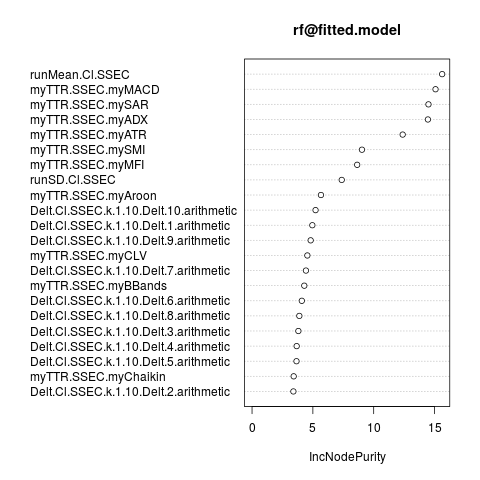

In [26]:
%%R
library(randomForest)
set.seed(42)

# X：技術分析、報酬率、移動平均、移動標準差
model <- specifyModel(formula=target~myTTR(SSEC)+Delt(Cl(SSEC),k=1:10)+runMean(Cl(SSEC))+runSD(Cl(SSEC)), na.rm=TRUE)
rf <- buildModel(x=model, method="randomForest", training.per=c(start(SSEC), index(SSEC["2011-10-12"])))#training.per=c(start_da, end_da)

#@: S4: http://adv-r.had.co.nz/S4.html
x <- importance(rf@fitted.model)
varImpPlot(rf@fitted.model)

In [27]:
%%R
rownames(x) [x >12]

[1] "myTTR.SSEC.myATR"  "myTTR.SSEC.myADX"  "myTTR.SSEC.myMACD"
[4] "myTTR.SSEC.mySAR"  "runMean.Cl.SSEC"  


##### 將資料從 22 個維度縮減為 5 個維度

In [12]:
%%R
myTTR.data <- myTTR(SSEC)[,c("myATR","myADX", "myMACD","mySAR" )]
model.data <- specifyModel(formula=target ~ myTTR.data + runMean(Cl(SSEC)))
train.data <- as.data.frame(modelData(model.data,data.window=c(start(SSEC),"2012-12-31")))
test.data <- as.data.frame(modelData(model.data, data.window=c(as.Date("2013-01-05"), end(SSEC))))

colnames(train.data) <- c("target", "myATR","myADX", "myMACD","mySAR", "runMean" )
colnames (test.data) <- c("target", "myATR","myADX", "myMACD","mySAR", "runMean" )
head(train.data)

               target    myATR    myADX      myMACD    mySAR  runMean
2007-02-27 0.03418219 102.4237 15.94273 -0.08934128 2683.452 2853.230
2007-02-28 0.14001353 106.2516 15.78291  0.10203645 2720.084 2869.720
2007-03-01 0.27584191 107.2451 15.63450  0.20364807 2753.053 2875.666
2007-03-02 0.27739792 104.4678 15.49669  0.26236579 2782.725 2885.780
2007-03-05 0.45364251 106.6755 15.84227  0.26459518 2785.306 2883.593
2007-03-06 0.39369161 106.8680 16.06185  0.26147397 2785.306 2884.424


####   4. 建模型：以 Support Vector Machine 做分類

In [13]:
%%R
library(e1071)
model.svm <- svm(target~., data=train.data, cost=100)

value.predicted <- predict(model.svm,na.omit(test.data))
value.true <- na.omit(test.data)$target
value <- data.frame(predicted=value.predicted, true=value.true)
head(value)

              predicted      true
2013-01-07  0.074259577 0.0000000
2013-01-08  0.046995725 0.0000000
2013-01-09  0.009440664 0.0000000
2013-01-10 -0.040832391 0.0000000
2013-01-11  0.010716994 0.1385232
2013-01-14  0.053419827 0.0000000


#### 5. 評估模型表現


* signal = 
    * Short, if target < a1 %
    * Buy, if target > a2 %
    * Hold, otherwise


In [14]:
%%R
T2Signal <- function(x,a1 = -0.01, a2 = 0.01)
{
  result <- ifelse(x < a1, "Short", ifelse(x > a2, "Buy", "Hold"))
  result <- factor(result)
  return(result)
}

signal <- data.frame(
    p = T2Signal(x=value$predicted, a1 = -0.095, a2 = 0.095),
    true = T2Signal(x=value$true, a1 = -0.095, a2 = 0.095)
)
head(signal)

     p true
1 Hold Hold
2 Hold Hold
3 Hold Hold
4 Hold Hold
5 Hold  Buy
6 Hold Hold


* Accuracy 定義為命中率
$$Accuracy = \frac{SS+HH+BB}{S+H+B}$$
* we only care about "Short" & "Buy", re-define $Accuracy$:
$$Accuracy = \frac{SS+BB}{S+B}$$

In [15]:
%%R
accuracy <- function(prediction, true)
{
  t <- table(prediction, true)
  result <- (t["Short", "Short"] + t["Buy","Buy"]) / (sum(t["Buy",]) + sum(t["Short",]))
  return(result)
}

accuracy(signal$p, signal$true)

[1] 0.7738095


##### 爆搜 a1, a2 值，以求精確度最好

In [16]:
%%R
get.accuracy <- function(a1, a2)
{
  signal <- data.frame(
    p = T2Signal(x=value$predicted, a1 = a1, a2 = a2),
    true = T2Signal(x=value$true, a1 = a1, a2 = a2)
  )
  accuracy(prediction=signal$p, true=signal$true)
}

a1s <- - seq(0.001, 0.2, length.out=50)
a2s <- seq(0.001, 0.2, length.out=50)

#reault might take for 5 seconds
result <- outer(X=a1s, Y=a2s, FUN = Vectorize(get.accuracy, vectorize.args=c("a1","a2")))
ind <- which(result == max(result), arr.ind=TRUE)
a1.optimal <- a1s[ind[, 1]]
a2.optimal <- a2s[ind[, 2]]
print(a1.optimal)
print(a2.optimal)
print(result[ind])

[1] -0.1675102
[1] 0.2
[1] 0.9295775


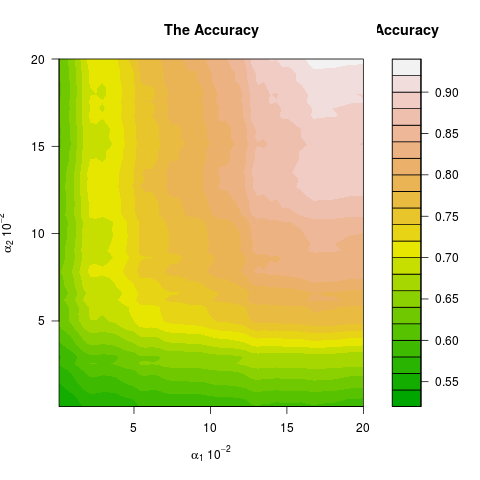

In [17]:
%%R
filled.contour(
    x= -a1s*100, 
    y=a2s*100, 
    z=result, 
    color= terrain.colors, 
    plot.title = title(main = "The Accuracy", xlab = expression(paste(alpha[1], " ", 10^-2)),  ylab = expression(paste(alpha[2], " ", 10^-2))),             
    key.title = title(main = "Accuracy"),
    key.axes = axis(4, seq(0, 1, by = 0.05))
)

# Thank you for your attention :)


#### Reference:
1. <a href='http://www.pcstore.com.tw/pchome24h/M19720645.htm'>基礎R語言與商業應用：第八章</a>

#### Special thanks to Clio Chen to schedule this study group!